### Colab setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
import os

def verify_unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.startswith('__MACOSX'):
                continue
            file_path = os.path.join(extract_to, file_name)
            if not os.path.exists(file_path):
                zip_ref.extract(file_name, extract_to)
                print(f"Extracted: {file_name}")
            # else:
            #     print(f"Skipped (already exists): {file_name}")

zip_path = "drive/MyDrive/deepship_baseline_unnorm_mat.zip"
extract_to = "data"

if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

verify_unzip_file(zip_path, extract_to)

### Imports

In [3]:
# Libraries
import os
from importlib import reload

import tensorflow as tf
import keras

import numpy as np
import matplotlib.pyplot as plt

# Scripts
from helpers import data, runners, utils, generators

In [4]:
# Should be v2.10
!pip show tensorflow

Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [5]:
# Should be v2.10
!pip show keras

Name: keras
Version: 3.5.0
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow


In [6]:
reload(runners)
reload(data)
reload(utils)
reload(generators)

<module 'helpers.generators' from '/content/helpers/generators.py'>

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use()

GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
np.random.seed(42)

## `main`

In [9]:
NUM_EPOCHS = 50
DATA_BATCH_SIZE = 16
GPU_BATCH_SIZE = 4

### Load data

In [10]:
all_files_df, ships = data.get_dataset_info(path_to_root="data", ext='mat')

# Filter ships which have multiple recordings
ships_multiple_recordings = {k: v for k, v in ships.items() if len(v) > 1}

# Get a list of all segments whose ships have multiple recordings
multiple_recordings_df = all_files_df[all_files_df["ship_name"].isin(ships_multiple_recordings)]

multiple_recordings_df

ship_name  class  \
0          SEASPAN_RAVEN    Tug   
1      SEASPAN_COMMANDER    Tug   
2          SEASPAN_RAVEN    Tug   
3          SEASPAN_RAVEN    Tug   
6           OCEAN_GORDON    Tug   
...                  ...    ...   
53492  PRINCESS_SUPERIOR  Cargo   
53496    SEASPAN_RELIANT  Cargo   
53497      SEASPAN_SWIFT  Cargo   
53499    SEASPAN_RELIANT  Cargo   
53501      SEASPAN_SWIFT  Cargo   

                                               file_path      date  seg  
0          data/Tug/SEASPAN_RAVEN-52-20171213_seg155.mat  20171213  155  
1      data/Tug/SEASPAN_COMMANDER-52-20171203_seg009.mat  20171203    9  
2          data/Tug/SEASPAN_RAVEN-52-20171221_seg042.mat  20171221   42  
3          data/Tug/SEASPAN_RAVEN-52-20171105_seg189.mat  20171105  189  
6           data/Tug/OCEAN_GORDON-52-20171203_seg173.mat  20171203  173  
...                                                  ...       ...  ...  
53492  data/Cargo/PRINCESS_SUPERIOR-79-20171128_seg01...  20171128   18  
53496  data/Cargo/SEASPAN_RELIANT-76-20171205_seg004.mat  20171205    4  
53497    data/Cargo/SEASPAN_SWIFT-70-20171104_seg007.mat  20171104    7  
53499  data/Cargo/SEASPAN_RELIANT-76-20171202_seg092.mat  20171202   92  
53501    data/Cargo/SEASPAN_SWIFT-70-20171120_seg066.mat  20171120   66  

[37377 rows x 5 columns]

In [11]:
# SEE train_val_test_split.xlsx FOR DETAILS
cargo_val_ships = ["ANASTASIA", "CAPRICORNUS_LEADER", "MERLIN_ARROW"]
cargo_test_ships = ["POYANG_477669100", "SEASPAN_RELIANT"]
passenger_val_ships = ["MAYNE_QUEEN", "V2V_EMPRESS"]
passenger_test_ships = ["NORTHERN_ADVENTURE", "OOSTERDAM", "SAFARI_QUEST", "SALISH_ORCA", "SALISH_RAVEN", "SEVEN_SEAS"]
tanker_val_ships = ["CABO_DE", "CHAMPION_CORNELIA", "CHAMPION_ISTRA", "NAVIG8_STELLAR"]
tanker_test_ships = ["ALFRED_N", "AMAGI_GALAXY", "ARGENT_DAISY", "ARGENT_SUNRISE", "ARISTOKLIS", "BOCHEM_LONDON", "CARIBBEAN_SPIRIT", "CHALLENGE_PRELUDE", "MTM_LONDON", "NAVE_ORBIT"]
tug_val_ships = ["OCEAN_BETTY"]
tug_test_ships = ["SEASPAN_EAGLE", "SEASPAN_QUEEN", "SEA_IMP"]

val_ships = cargo_val_ships + passenger_val_ships + tanker_val_ships + tug_val_ships
test_ships = cargo_test_ships + passenger_test_ships + tanker_test_ships + tug_test_ships

train_df = multiple_recordings_df[~multiple_recordings_df["ship_name"].isin(val_ships + test_ships)]
val_df = multiple_recordings_df[multiple_recordings_df["ship_name"].isin(val_ships)]
test_df = multiple_recordings_df[multiple_recordings_df["ship_name"].isin(test_ships)]

In [12]:
reload(generators)

# Initialise generators
train_gen = generators.N2NDeepShipGenerator(
    multiple_recordings_df,
    'mat',
    'Ptrans',
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    conv_channel=True
)

val_gen = generators.N2NDeepShipGenerator(
    val_df,
    'mat',
    'Ptrans',
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    conv_channel=True
)

test_gen = generators.N2NDeepShipGenerator(
    test_df,
    'mat',
    'Ptrans',
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    conv_channel=True
)

### Initialise model

In [13]:
from models import irfan_2020, unet_n2n

model = irfan_2020.get_irfan_model(input_shape=(192, 192, 1))
# model = unet_n2n.get_unet_model(input_shape=(192, 192, 1))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    loss=keras.losses.MeanSquaredError(),
    metrics=[utils.ssim]
)

model.summary()

Model: "irfan_2020"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 192, 192, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 192, 192, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 192, 192, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 192, 192, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 96, 96, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 96, 96, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (MaxPooling2D)        │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,407,105 (5.37 MB)

 Trainable params: 1,405,057 (5.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

### Train model

In [14]:
csv_logger = keras.callbacks.CSVLogger(
    filename="drive/MyDrive/saved_models/diff_spec_irfan/training.log",
    separator=",",
    append=False
)

backup_callback = keras.callbacks.BackupAndRestore(
    backup_dir="drive/MyDrive/saved_models/diff_spec_irfan/tmp"
)

In [15]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[csv_logger, backup_callback],
    verbose=2
)

Epoch 1/50
2336/2336 - 255s - 109ms/step - loss: 0.0238 - ssim: 0.1103 - val_loss: 0.0227 - val_ssim: 0.1053
Epoch 2/50
2336/2336 - 242s - 104ms/step - loss: 0.0214 - ssim: 0.1129 - val_loss: 0.0225 - val_ssim: 0.1061
Epoch 3/50
2336/2336 - 241s - 103ms/step - loss: 0.0213 - ssim: 0.1132 - val_loss: 0.0221 - val_ssim: 0.1062
Epoch 4/50
2336/2336 - 239s - 102ms/step - loss: 0.0211 - ssim: 0.1134 - val_loss: 0.0222 - val_ssim: 0.1067
Epoch 5/50
2336/2336 - 241s - 103ms/step - loss: 0.0210 - ssim: 0.1136 - val_loss: 0.0222 - val_ssim: 0.1068
Epoch 6/50
2336/2336 - 243s - 104ms/step - loss: 0.0210 - ssim: 0.1138 - val_loss: 0.0223 - val_ssim: 0.1071
Epoch 7/50
2336/2336 - 240s - 103ms/step - loss: 0.0209 - ssim: 0.1139 - val_loss: 0.0222 - val_ssim: 0.1069
Epoch 8/50
2336/2336 - 241s - 103ms/step - loss: 0.0208 - ssim: 0.1142 - val_loss: 0.0224 - val_ssim: 0.1065
Epoch 9/50
2336/2336 - 242s - 104ms/step - loss: 0.0207 - ssim: 0.1142 - val_loss: 0.0223 - val_ssim: 0.1069
Epoch 10/50
2336/23

In [16]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

466/466 - 41s - 89ms/step - loss: 0.0209 - ssim: 0.1177


In [ ]:
model.save('drive/MyDrive/saved_models/diff_spec_irfan/irfan_denoiser_50epochs.keras')

### Evaluation, metrics, and visualising denoised output

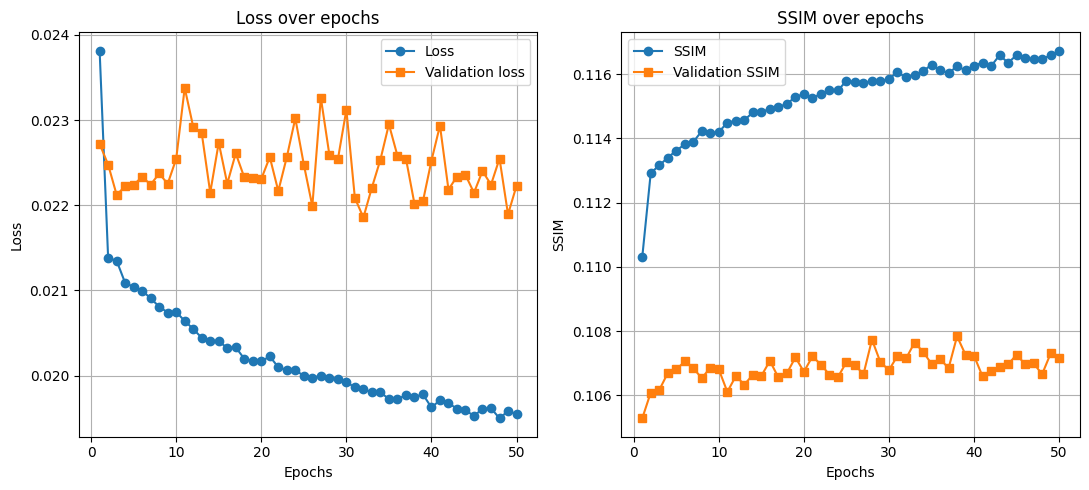

In [18]:
reload(utils)
fig = utils.get_psnr_loss_ssim_curves(history, together=True, plots=['ssim', 'loss'])
fig.savefig("drive/MyDrive/saved_models/diff_spec_irfan/img/loss_ssim_curves.pdf")

In [19]:
# Get a few samples from the test generator for visualisation and metrics calculation
num_samples = 5

sample_X, sample_y = next(iter(test_gen))
sample_inputs = sample_X[:num_samples]  # Extract the first `num_samples` examples from the batch
sample_outputs = sample_y[:num_samples]  # Extract the first `num_samples` examples from the batch

# Predict the denoised outputs
denoised_outputs = model.predict(sample_inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [20]:
print("Shape of sample_inputs:", sample_inputs.shape)
print("Shape of denoised_outputs:", denoised_outputs.shape)

Shape of sample_inputs: (5, 192, 192, 1)
Shape of denoised_outputs: (5, 192, 192, 1)


In [21]:
# Get evaluation metrics
mse_score = tf.keras.losses.MeanSquaredError()(sample_inputs, denoised_outputs).numpy()
ssim_score = utils.ssim(sample_inputs, denoised_outputs).numpy()

print(f"MSE on sample batch: {mse_score}")
print(f"SSIM on sample batch: {ssim_score}")

MSE on sample batch: 0.016038158908486366
SSIM on sample batch: [0.11042523 0.11711545 0.10823964 0.10476958 0.10913207]


In [22]:
# Check if all outputs are normalised
for i, output in enumerate(denoised_outputs):
    print(f"Sample {i+1} - Min: {np.min(output)}; Max: {np.max(output)}")

Sample 1 - Min: 0.39212536811828613; Max: 0.7451523542404175
Sample 2 - Min: 0.3862437307834625; Max: 0.7634682059288025
Sample 3 - Min: 0.40183377265930176; Max: 0.7473955154418945
Sample 4 - Min: 0.3928461968898773; Max: 0.7696612477302551
Sample 5 - Min: 0.3939170241355896; Max: 0.7679425477981567


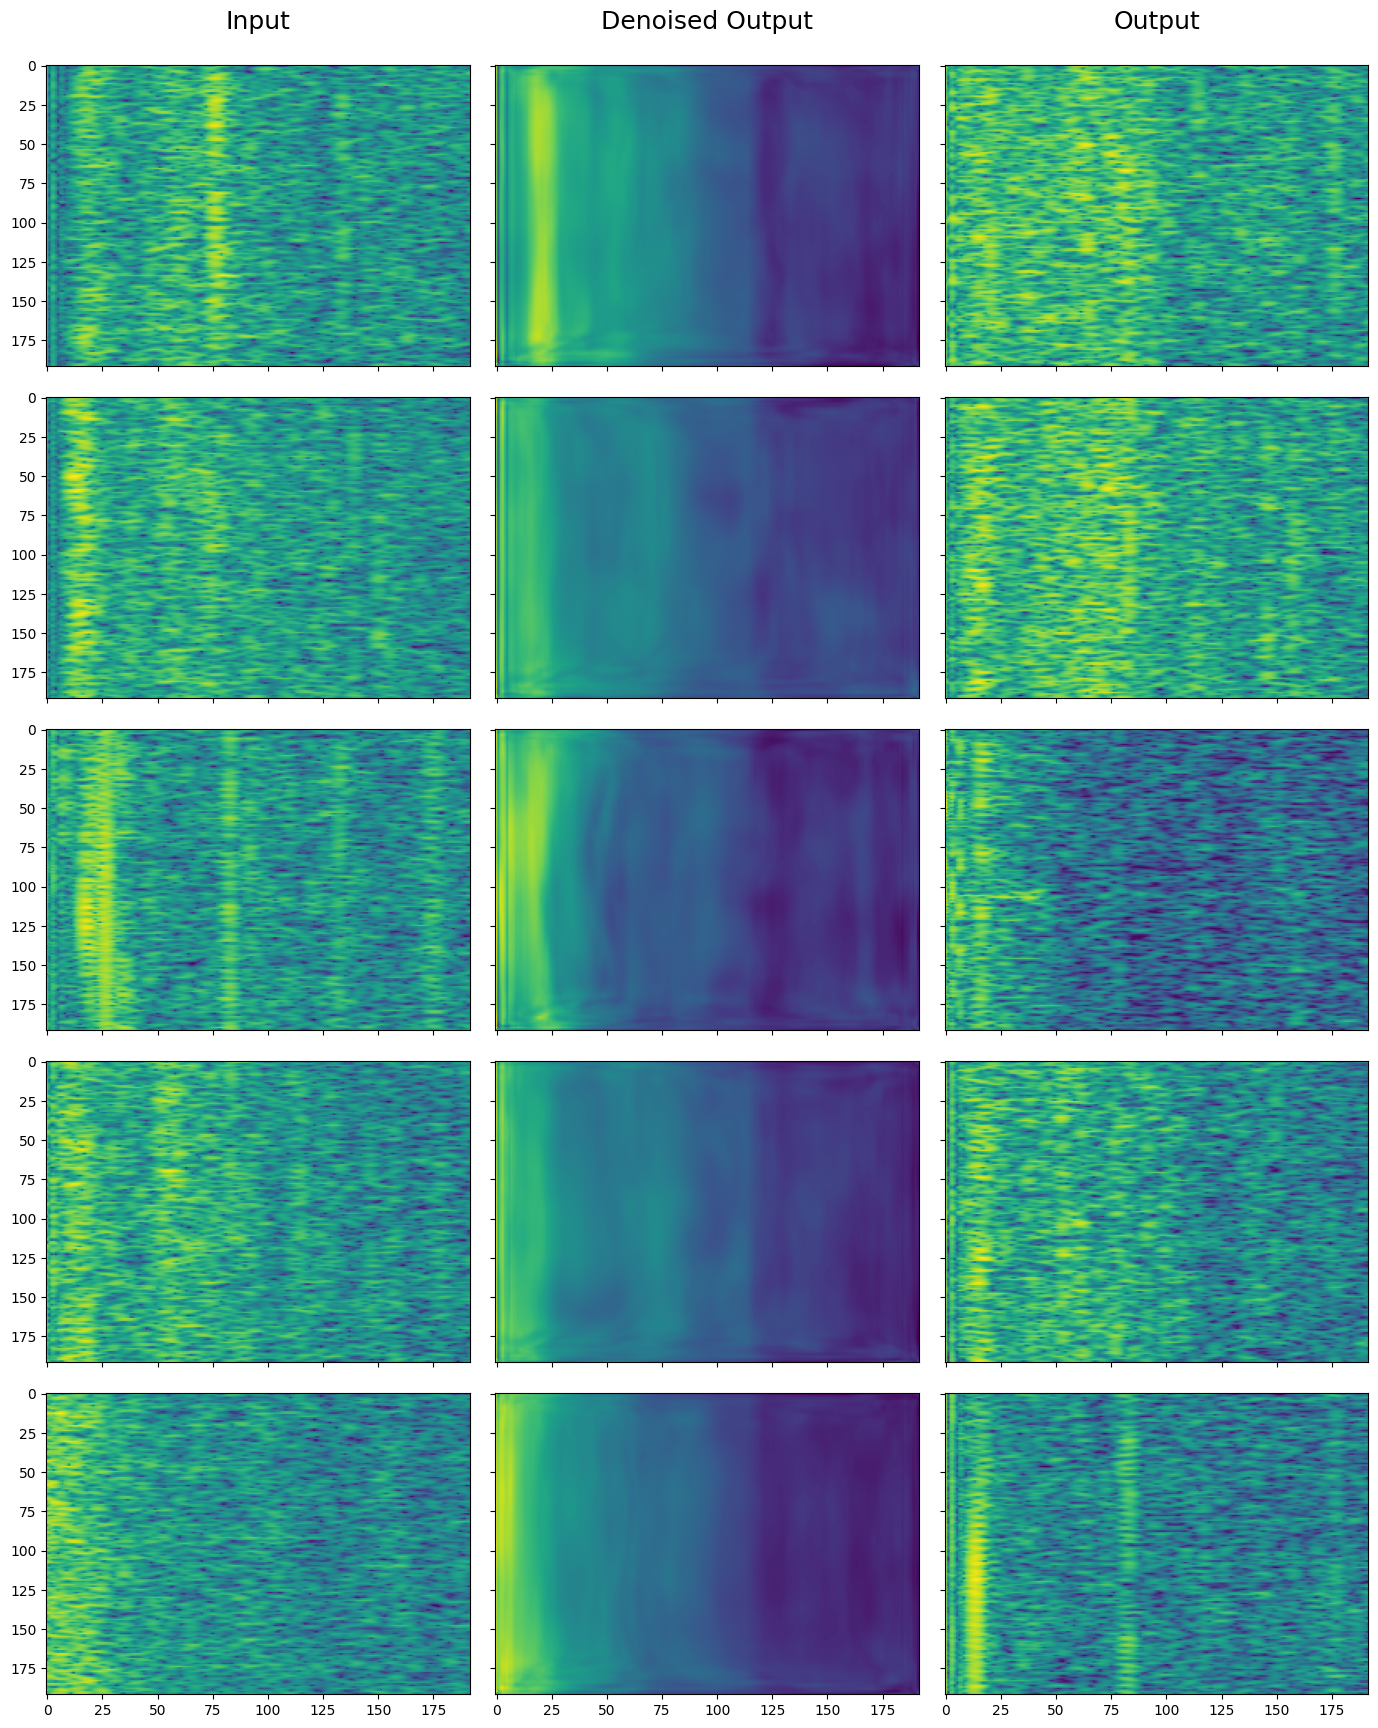

In [23]:
# Create a single figure
fig, axes = plt.subplots(num_samples, 3, figsize=(14, num_samples * 3.5), sharex=True, sharey=True)

# fig.tight_layout(pad=3.0)

for i in range(num_samples):
    axes[i, 0].imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    axes[i, 1].imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    axes[i, 2].imshow(sample_outputs[i].squeeze(), cmap="viridis", aspect="auto")

axes[0, 0].set_title(f"Input\n", fontsize=18)
axes[0, 1].set_title(f"Denoised Output\n", fontsize=18)
axes[0, 2].set_title(f"Output\n", fontsize=18)

fig.tight_layout(pad=1.5)
fig.savefig(f"drive/MyDrive/saved_models/diff_spec_irfan/img/combined_spectrograms.pdf", bbox_inches="tight")

plt.show()

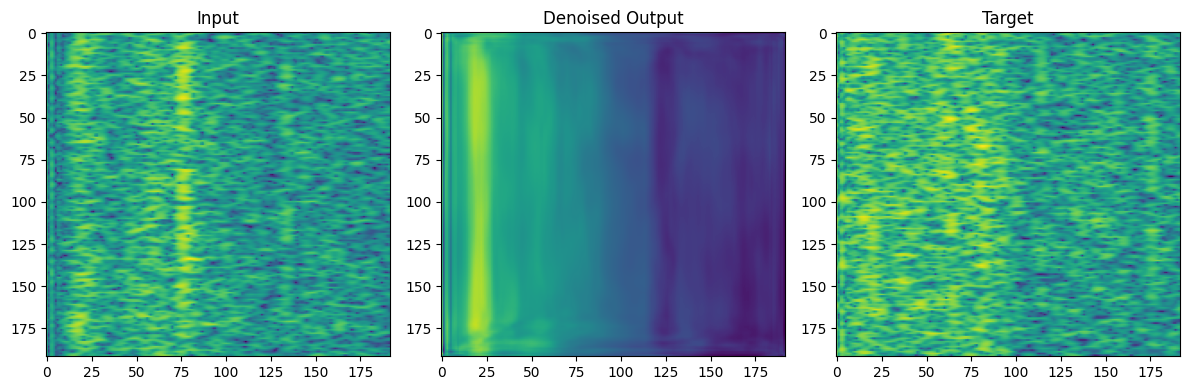

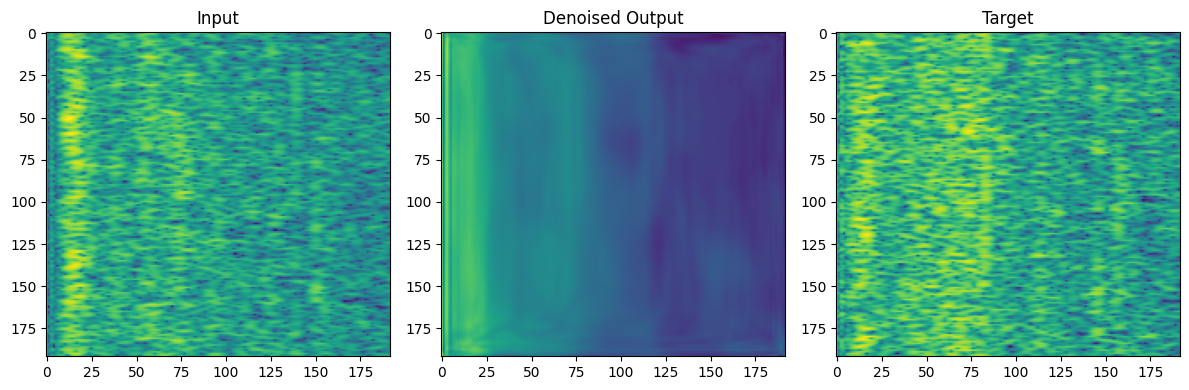

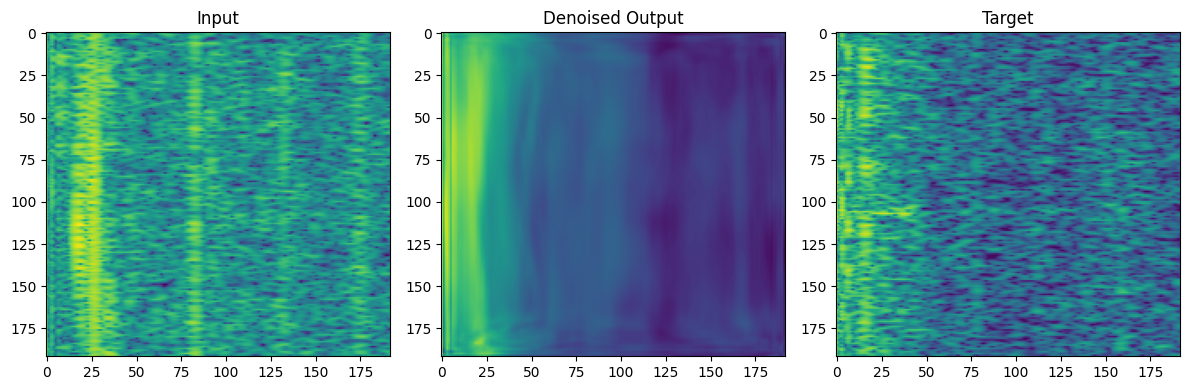

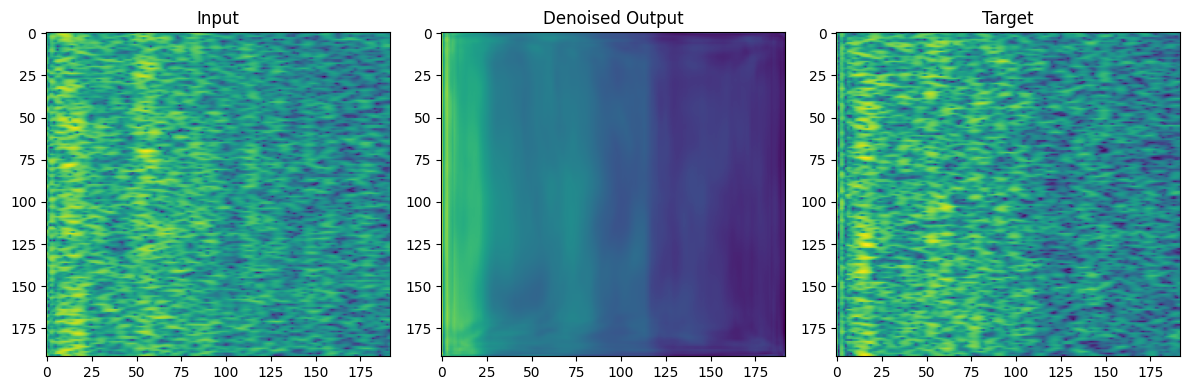

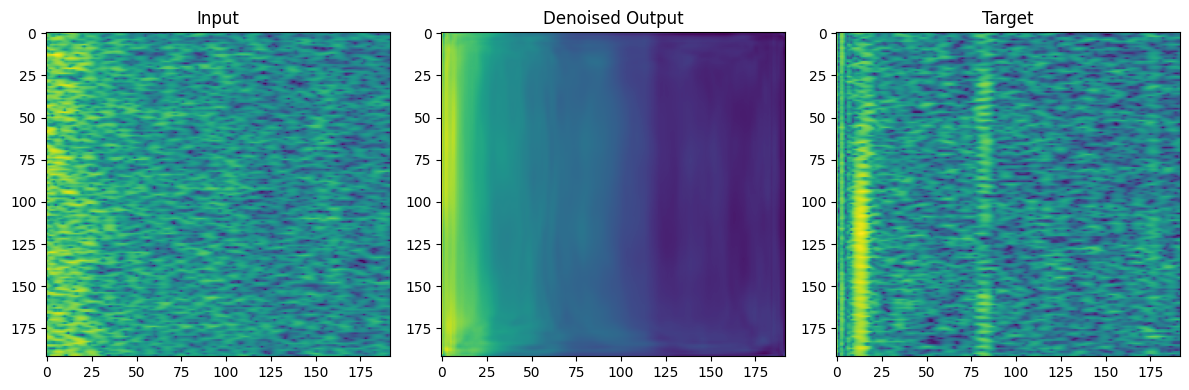

In [24]:
# Plot the input, output, and target spectrograms for each sample
for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    # INPUT
    plt.subplot(1, 3, 1)
    plt.imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Input")
    # plt.colorbar()

    # DENOISED OUTPUT
    plt.subplot(1, 3, 2)
    plt.imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Denoised Output")
    # plt.colorbar()

    # TARGET
    plt.subplot(1, 3, 3)
    plt.imshow(sample_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Target")
    # plt.colorbar()

    plt.tight_layout()
    plt.show()